<a href="https://colab.research.google.com/github/tegar17/ShareTask_DeepLearning/blob/main/ShareTask_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/tegar17/ShareTask_DeepLearning.git

Cloning into 'ShareTask_DeepLearning'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 2), reused 14 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 1.14 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
pip install bert_sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, RobertaTokenizer, BertModel, RobertaModel
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import MSELoss
import torch.nn as nn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")


Using device: cuda



Load dataset

In [ ]:
df = pd.read_csv("/content/ShareTask_DeepLearning/train/lcp_single_train.tsv", sep="\t")

Cek baris yang ada null value

In [ ]:
print(df.isnull().sum())

id            0
corpus        0
sentence      0
token         7
complexity    0
dtype: int64


hapus baris yang ada null value

In [ ]:
df = df.dropna()
df = df[df['sentence'].str.len() > 0]
df = df[df['token'].str.len() > 0]
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
class LexicalComplexityDatasetDual(Dataset):
    def __init__(self, dataframe, roberta_tokenizer, bert_tokenizer, max_length=128):
        self.data = dataframe
        self.roberta_tokenizer = roberta_tokenizer
        self.bert_tokenizer = bert_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        token_text = str(row['token'])
        sentence_text = str(row['sentence'])
        complexity = torch.tensor(row['complexity'], dtype=torch.float)

        # === RoBERTa Tokenization ===
        # RoBERTa Input 1: Token-only
        roberta_token_encoding = self.roberta_tokenizer(
            token_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # RoBERTa Input 2: Sentence-context
        roberta_sentence_encoding = self.roberta_tokenizer(
            sentence_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # === BERT Tokenization ===
        # BERT Input 1: Token-only
        bert_token_encoding = self.bert_tokenizer(
            token_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # BERT Input 2: Sentence-context
        bert_sentence_encoding = self.bert_tokenizer(
            sentence_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            # RoBERTa inputs
            'roberta_token_input_ids': roberta_token_encoding['input_ids'].flatten(),
            'roberta_token_attention_mask': roberta_token_encoding['attention_mask'].flatten(),
            'roberta_sentence_input_ids': roberta_sentence_encoding['input_ids'].flatten(),
            'roberta_sentence_attention_mask': roberta_sentence_encoding['attention_mask'].flatten(),

            # BERT inputs
            'bert_token_input_ids': bert_token_encoding['input_ids'].flatten(),
            'bert_token_attention_mask': bert_token_encoding['attention_mask'].flatten(),
            'bert_sentence_input_ids': bert_sentence_encoding['input_ids'].flatten(),
            'bert_sentence_attention_mask': bert_sentence_encoding['attention_mask'].flatten(),

            # Target
            'labels': complexity
        }


In [ ]:
class EnsembleComplexityModel(nn.Module):
    def __init__(self):
        super(EnsembleComplexityModel, self).__init__()

        # 4 model terpisah sesuai diagram
        self.roberta_model1 = RobertaModel.from_pretrained('roberta-base')
        self.roberta_model2 = RobertaModel.from_pretrained('roberta-base')
        self.bert_model1 = BertModel.from_pretrained('bert-base-uncased')
        self.bert_model2 = BertModel.from_pretrained('bert-base-uncased')

        # Regression heads untuk masing-masing model
        self.regressor_roberta1 = nn.Linear(768, 1)
        self.regressor_roberta2 = nn.Linear(768, 1)
        self.regressor_bert1 = nn.Linear(768, 1)
        self.regressor_bert2 = nn.Linear(768, 1)

        # Weights untuk weighted averaging (sesuai diagram)
        self.weight_roberta1 = 0.8
        self.weight_roberta2 = 0.2
        self.weight_bert1 = 0.8
        self.weight_bert2 = 0.2

        self.dropout = nn.Dropout(0.1)

    def forward(self,
                roberta_token_input_ids, roberta_token_attention_mask,
                roberta_sentence_input_ids, roberta_sentence_attention_mask,
                bert_token_input_ids, bert_token_attention_mask,
                bert_sentence_input_ids, bert_sentence_attention_mask):

        # RoBERTa Model 1 (Token)
        roberta1_output = self.roberta_model1(
            input_ids=roberta_token_input_ids,
            attention_mask=roberta_token_attention_mask
        )
        roberta1_pred = self.regressor_roberta1(self.dropout(roberta1_output.pooler_output))

        # RoBERTa Model 2 (Sentence)
        roberta2_output = self.roberta_model2(
            input_ids=roberta_sentence_input_ids,
            attention_mask=roberta_sentence_attention_mask
        )
        roberta2_pred = self.regressor_roberta2(self.dropout(roberta2_output.pooler_output))

        # BERT Model 1 (Token)
        bert1_output = self.bert_model1(
            input_ids=bert_token_input_ids,
            attention_mask=bert_token_attention_mask
        )
        bert1_pred = self.regressor_bert1(self.dropout(bert1_output.pooler_output))

        # BERT Model 2 (Sentence)
        bert2_output = self.bert_model2(
            input_ids=bert_sentence_input_ids,
            attention_mask=bert_sentence_attention_mask
        )
        bert2_pred = self.regressor_bert2(self.dropout(bert2_output.pooler_output))

        # Weighted Averaging untuk RoBERTa
        roberta_weighted = (self.weight_roberta1 * roberta1_pred + self.weight_roberta2 * roberta2_pred)


        # Weighted Averaging untuk BERT
        bert_weighted = (self.weight_bert1 * bert1_pred + self.weight_bert2 * bert2_pred)

        # Final Simple Averaging
        final_prediction = (roberta_weighted + bert_weighted) / 2

        return final_prediction

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize ensemble model
model = EnsembleComplexityModel().to(device)

# Create datasets with dual tokenizers (FIXED: menggunakan class yang benar)
train_dataset = LexicalComplexityDatasetDual(train_df, roberta_tokenizer, bert_tokenizer)
val_dataset = LexicalComplexityDatasetDual(val_df, roberta_tokenizer, bert_tokenizer)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)

# Optional: Add learning rate scheduler for better convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in dataloader:
        # Move batch to device - FIXED: menggunakan key yang benar
        roberta_token_input_ids = batch['roberta_token_input_ids'].to(device)
        roberta_token_attention_mask = batch['roberta_token_attention_mask'].to(device)
        roberta_sentence_input_ids = batch['roberta_sentence_input_ids'].to(device)
        roberta_sentence_attention_mask = batch['roberta_sentence_attention_mask'].to(device)

        bert_token_input_ids = batch['bert_token_input_ids'].to(device)
        bert_token_attention_mask = batch['bert_token_attention_mask'].to(device)
        bert_sentence_input_ids = batch['bert_sentence_input_ids'].to(device)
        bert_sentence_attention_mask = batch['bert_sentence_attention_mask'].to(device)

        labels = batch['labels'].to(device)

        # Forward pass - model sudah melakukan weighted averaging di dalam
        final_pred = model(
            roberta_token_input_ids, roberta_token_attention_mask,
            roberta_sentence_input_ids, roberta_sentence_attention_mask,
            bert_token_input_ids, bert_token_attention_mask,
            bert_sentence_input_ids, bert_sentence_attention_mask
        )

        # Calculate loss
        loss = criterion(final_pred.squeeze(), labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device - FIXED
            roberta_token_input_ids = batch['roberta_token_input_ids'].to(device)
            roberta_token_attention_mask = batch['roberta_token_attention_mask'].to(device)
            roberta_sentence_input_ids = batch['roberta_sentence_input_ids'].to(device)
            roberta_sentence_attention_mask = batch['roberta_sentence_attention_mask'].to(device)

            bert_token_input_ids = batch['bert_token_input_ids'].to(device)
            bert_token_attention_mask = batch['bert_token_attention_mask'].to(device)
            bert_sentence_input_ids = batch['bert_sentence_input_ids'].to(device)
            bert_sentence_attention_mask = batch['bert_sentence_attention_mask'].to(device)

            labels = batch['labels'].to(device)

            # Forward pass
            final_pred = model(
                roberta_token_input_ids, roberta_token_attention_mask,
                roberta_sentence_input_ids, roberta_sentence_attention_mask,
                bert_token_input_ids, bert_token_attention_mask,
                bert_sentence_input_ids, bert_sentence_attention_mask
            )

            loss = criterion(final_pred.squeeze(), labels)

            total_loss += loss.item()
            all_preds.extend(final_pred.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Pearson correlation
    pearson_corr, _ = pearsonr(all_preds, all_labels)

    return total_loss / len(dataloader), pearson_corr, all_preds, all_labels

# 5. RUN TRAINING

print("Starting training...")
best_pearson = 0

for epoch in range(3):  # Sesuai paper mereka pakai 3 epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, pearson_corr, val_preds, val_labels = evaluate_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Pearson Correlation: {pearson_corr:.4f}")

    # Update scheduler
    scheduler.step(val_loss)

    # Save best model
    if pearson_corr > best_pearson:
        best_pearson = pearson_corr
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  ✓ Best model saved! (Pearson: {best_pearson:.4f})")

print(f"\nTraining completed! Best Pearson Correlation: {best_pearson:.4f}")

Starting training...
Epoch 1:
  Train Loss: 0.0118
  Val Loss: 0.0074
  Pearson Correlation: 0.7545
  ✓ Best model saved! (Pearson: 0.7545)
Epoch 2:
  Train Loss: 0.0075
  Val Loss: 0.0075
  Pearson Correlation: 0.7690
  ✓ Best model saved! (Pearson: 0.7690)
Epoch 3:
  Train Loss: 0.0061
  Val Loss: 0.0074
  Pearson Correlation: 0.7565

Training completed! Best Pearson Correlation: 0.7690


In [ ]:
df_test = pd.read_csv("/content/ShareTask_DeepLearning/test-label/lcp_single_test.tsv", sep="\t")

In [ ]:
# Load best model
model = EnsembleComplexityModel().to(device)
model.load_state_dict(torch.load('best_model.pth', map_location=device))

# Drop null values dari test dataset
df_test = df_test.dropna()
df_test = df_test[df_test['sentence'].str.len() > 0]
df_test = df_test[df_test['token'].str.len() > 0]

# Create test dataset
test_dataset = LexicalComplexityDatasetDual(df_test, roberta_tokenizer, bert_tokenizer)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate on test set
test_loss, test_pearson, test_preds, test_labels = evaluate_epoch(model, test_loader, criterion, device)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Pearson Correlation: {test_pearson:.4f}")
print(f"Number of test samples: {len(test_preds)}")
print("="*50)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TEST SET RESULTS
Test Loss (MSE): 0.0079
Pearson Correlation: 0.7590
Number of test samples: 887



Top 10 Predictions (sorted by absolute error):
          token  actual_complexity  predicted_complexity  absolute_error
239    wormwood           0.732143              0.399913        0.332230
253        role           0.000000              0.292084        0.292084
6         armor           0.027778              0.308324        0.280546
540     gametes           0.750000              0.471982        0.278018
212      boughs           0.666667              0.403747        0.262920
26   yourselves           0.066667              0.324682        0.258015
4      entrance           0.000000              0.257220        0.257220
246       clods           0.625000              0.370047        0.254953
39    twentieth           0.117647              0.371428        0.253781
375   therapies           0.200000              0.447474        0.247474


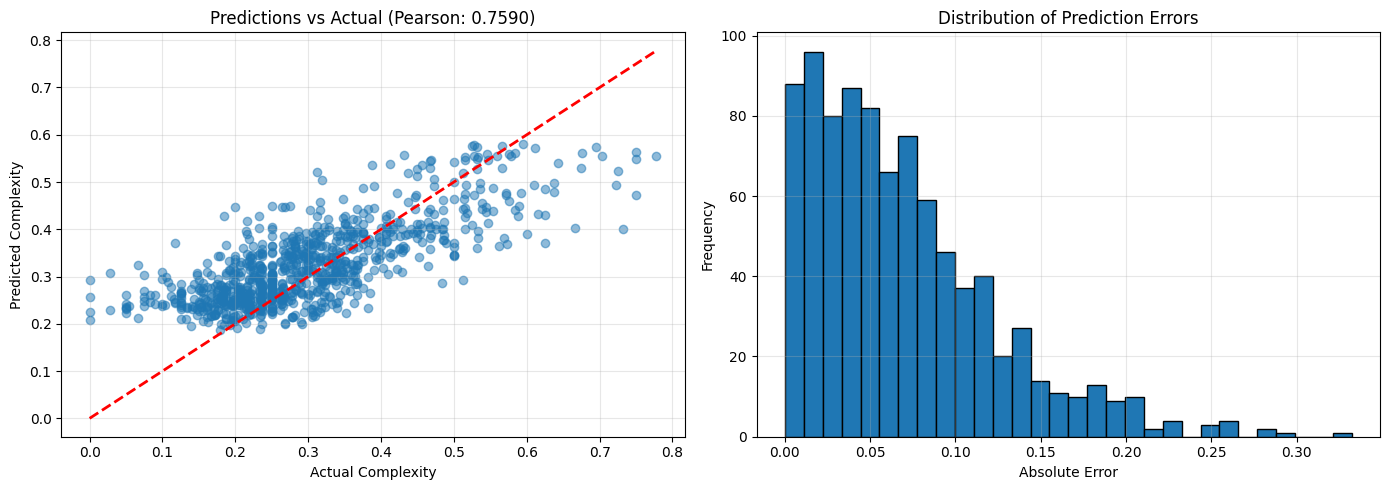


Mean Absolute Error: 0.0693
Std Dev of Error: 0.0544


In [ ]:
# Comparison: Predicted vs Actual
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    'token': df_test['token'].values,
    'sentence': df_test['sentence'].values,
    'actual_complexity': test_labels,
    'predicted_complexity': test_preds,
    'absolute_error': np.abs(np.array(test_preds) - np.array(test_labels))
})

print("\nTop 10 Predictions (sorted by absolute error):")
print(results_df.nlargest(10, 'absolute_error')[['token', 'actual_complexity', 'predicted_complexity', 'absolute_error']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Scatter plot of predictions vs actual
axes[0].scatter(test_labels, test_preds, alpha=0.5)
axes[0].plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--', lw=2)
axes[0].set_xlabel('Actual Complexity')
axes[0].set_ylabel('Predicted Complexity')
axes[0].set_title(f'Predictions vs Actual (Pearson: {test_pearson:.4f})')
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of errors
axes[1].hist(results_df['absolute_error'], bins=30, edgecolor='black')
axes[1].set_xlabel('Absolute Error')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Distribution of Prediction Errors')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMean Absolute Error: {results_df['absolute_error'].mean():.4f}")
print(f"Std Dev of Error: {results_df['absolute_error'].std():.4f}")